# Schelling Segregation Model

## Background

The Schelling (1971) segregation model is a classic of agent-based modeling, demonstrating how agents following simple rules lead to the emergence of qualitatively different macro-level outcomes. Agents are randomly placed on a grid. There are two types of agents, one constituting the majority and the other the minority. All agents want a certain number (generally, 3) of their 8 surrounding neighbors to be of the same type in order for them to be happy. Unhappy agents will move to a random available grid space. While individual agents do not have a preference for a segregated outcome (e.g. they would be happy with 3 similar neighbors and 5 different ones), the aggregate outcome is nevertheless heavily segregated.

## Implementation

This is a demonstration of running a Mesa model in an IPython Notebook. The actual model and agent code are implemented in Schelling.py, in the same directory as this notebook. Below, we will import the model class, instantiate it, run it, and plot the time series of the number of happy agents.

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from model import SchellingModel
from SALib.sample import saltelli
import numpy as np
import math

import pandas as pd

Now we instantiate a model instance: a 10x10 grid, with an 80% change of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 3 similar neighbors.

In [9]:
model = SchellingModel(25, 25, 0.0015, 0.025, 0.50, 0.005,0.5)

We want to run the model until all the agents are happy with where they are. However, there's no guarentee that a given model instantiation will *ever* settle down. So let's run it for either 100 steps or until it stops on its own, whichever comes first:

In [10]:
while model.running and model.schedule.steps < 3000:
    model.step()
print(model.schedule.steps) # Show how many steps have actually run

2631


The model has a DataCollector object, which checks and stores how many agents are happy at the end of each step. It can also generate a pandas DataFrame of the data it has collected:

In [11]:
model_out = model.datacollector.get_model_vars_dataframe()

In [12]:
model_out.head()

,condition,income,state,status
0,0.495893,0.492280,0.494087,0.495031
1,0.494391,0.480893,0.487642,0.485668
2,0.494086,0.476051,0.485068,0.479243
3,0.493214,0.468106,0.480660,0.469386
4,0.492323,0.468111,0.480217,0.471380


Finally, we can plot the 'happy' series:

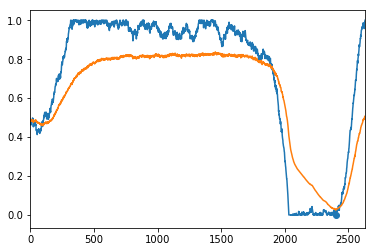

In [13]:
model_out.status.plot()
model_out.state.plot()
plt.scatter(model.last_bottom,0)

For testing purposes, here is a table giving each agent's x and y values at each step.

In [14]:
model.gent_time

19.166666666666668

In [15]:
x_positions = model.datacollector.get_agent_vars_dataframe()

In [16]:
x_positions.head()

x   y
Step AgentID        
0    (0, 0)    6  12
     (0, 1)   23   9
     (0, 2)   13   2
     (0, 3)   17   7
     (0, 4)   21   1

# Parameter sweeps for OFAT analysis

Now, we can do a parameter sweep to see how segregation changes with homophily.

First, we create a function which takes a model instance and returns what fraction of agents are segregated -- that is, have no neighbors of the opposite type.

In [17]:
from mesa.batchrunner import BatchRunner

In [18]:
def get_gent_time(model):
    return model.gent_time

In [37]:
def plot_gentrification_analysis(df,N_params,iterations,param_vals,x_label):
    gent_times = np.array(df['Gentrification time']).reshape(N_params,iterations)

    means = np.zeros(N_params)
    confs = np.zeros(N_params)
    for n in range(N_params):
        times = gent_times[n,:][~np.isnan(gent_times[n,:])]
        means[n] = np.sum(times) / times.size
        S = np.sqrt(np.sum((times-means[n])**2) / (times.size-1))
        confs[n] = 1.96*S / np.sqrt(times.size)

    plt.errorbar(np.linspace(0.01, 0.1, 20),means,confs,fmt="o")
    plt.ylabel('Gentrification time')
    plt.xlabel(x_label)
    plt.grid(True)

# Effect of a distance gradient on gentrification time

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's hold everything fixed except for Homophily.

In [12]:
#fixed_params = {"height": 25, "width": 25, "depreciation_rate": 0.0015, "stat_var": 0.02, "status": 0.5} 
variable_parms = {"d_factor": np.linspace(0.00, 2., 20)}
parms = {"height": 25, "width": 25, "depreciation_rate": 0.0015,"mobility": 0.02, "status": 0.5, "stat_var": 0.010}

In [13]:
model_reporters = {"Gentrification time": get_gent_time}

In [14]:
param_sweep = BatchRunner(SchellingModel, 
                          variable_parameters=variable_parms, 
                          fixed_parameters=parms,
                          iterations=50, 
                          max_steps=3000,
                          model_reporters=model_reporters)

In [15]:
param_sweep.run_all()

1000it [8:39:53, 36.73s/it]


In [16]:
df = param_sweep.get_model_vars_dataframe()

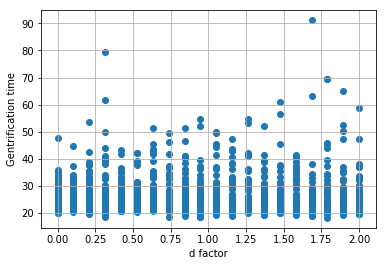

In [17]:
plt.scatter(df.d_factor, df["Gentrification time"])
plt.ylabel('Gentrification time')
plt.xlabel('d factor')
plt.grid(True)

In [61]:
#save dataframe
df.to_pickle("data/d_factor_runs.pkl")

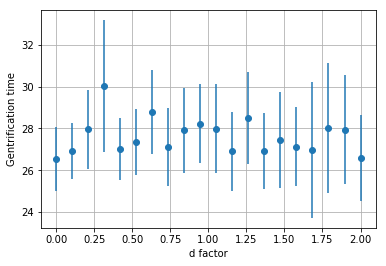

In [50]:
plot_gentrification_analysis(df,20,50,np.linspace(0.0,2.0,20),'d_factor')
plt.show()

In [62]:
new_df = pd.read_pickle("data/d_factor_runs.pkl")
print(new_df)

     d_factor  Run  Gentrification time
0         0.0    0            35.083333
1         0.0    1            20.833333
2         0.0    2            32.166667
3         0.0    3            33.416667
4         0.0    4            21.500000
5         0.0    5            27.083333
6         0.0    6                  NaN
7         0.0    7            29.500000
8         0.0    8            26.833333
9         0.0    9            25.666667
10        0.0   10            32.750000
11        0.0   11            20.000000
12        0.0   12            25.666667
13        0.0   13            27.416667
14        0.0   14            21.666667
15        0.0   15            25.500000
16        0.0   16            23.416667
17        0.0   17            35.916667
18        0.0   18            23.916667
19        0.0   19            47.500000
20        0.0   20            28.500000
21        0.0   21            23.833333
22        0.0   22            32.500000
23        0.0   23            30.500000


# Effect of status variability on gentrification time

In [23]:
#fixed_params = {"height": 25, "width": 25, "depreciation_rate": 0.0015, "stat_var": 0.02, "status": 0.5} 
variable_parms = {"stat_var": np.linspace(0.01, 0.1, 20)}
parms = {"height": 25, "width": 25, "depreciation_rate": 0.0015,"mobility": 0.02, "status": 0.5, "d_factor": 0.0}

In [24]:
model_reporters = {"Gentrification time": get_gent_time}

In [25]:
param_sweep = BatchRunner(SchellingModel, 
                          variable_parameters=variable_parms, 
                          fixed_parameters=parms,
                          iterations=50, 
                          max_steps=3000,
                          model_reporters=model_reporters)

In [26]:
param_sweep.run_all()

1000it [4:46:47,  7.22s/it]


In [27]:
df = param_sweep.get_model_vars_dataframe()

In [28]:
#save dataframe
df.to_pickle("data/stat_var_runs.pkl")

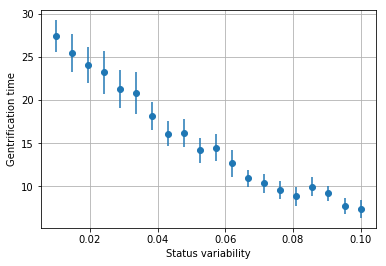

In [39]:
plot_gentrification_analysis(df,20,50,np.linspace(0.01, 0.1, 20),'Status variability')
plt.show()

# Effects of agent mobility on gentrification time

In [40]:
#fixed_params = {"height": 25, "width": 25, "depreciation_rate": 0.0015, "stat_var": 0.02, "status": 0.5} 
variable_parms = {"mobility": np.linspace(0.01, 0.1, 20)}
parms = {"height": 25, "width": 25, "depreciation_rate": 0.0015,"stat_var": 0.010, "status": 0.5, "d_factor": 0.0}

In [41]:
model_reporters = {"Gentrification time": get_gent_time}

In [42]:
param_sweep = BatchRunner(SchellingModel, 
                          variable_parameters=variable_parms, 
                          fixed_parameters=parms,
                          iterations=50, 
                          max_steps=3000,
                          model_reporters=model_reporters)

In [43]:
param_sweep.run_all()

1000it [7:35:40, 17.60s/it]


In [44]:
df = param_sweep.get_model_vars_dataframe()

In [45]:
#save dataframe
df.to_pickle("data/mobility_runs.pkl")

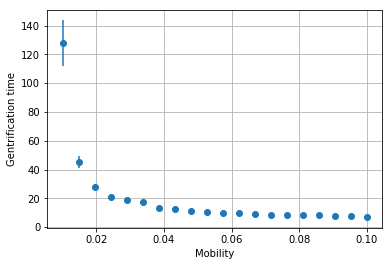

In [46]:
plot_gentrification_analysis(df,20,50,np.linspace(0.01, 0.1, 20),'Mobility')
plt.show()